<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This binary classification model detects malaria by classifying individual red blood cell images as infected or uninfected.
# It utilizes a dataset of 27,558 cell images from thin blood smear slides, containing both parasitized and healthy cells.
# The model leverages deep learning techniques to automate malaria detection, potentially aiding in faster and more accurate diagnosis.
### Link to the dataset: https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html
### Class - Parasitized and Uninfected

In [ ]:
!pip install -U albumentations

In [ ]:
!pip install wandb

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import random
from google.colab import files, drive
from PIL import Image
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomZoom
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yeabsiramersha58 (yeabsiramersha58-beijing-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 5,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [6]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])
print(dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.P27XWC_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [7]:
k = 0
for image, label in dataset[0]:
    with open(f'dataset/malaria_dataset_{k}.npz', mode='wb') as file:
        np.savez(file, image=image.numpy(), label=label.numpy())
    k += 1

    if k % 1000 == 0:
        print(k)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [4]:
def load_original_data():
  with wandb.init(project="Malaria-Diagnosis") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [ ]:
load_original_data()

In [ ]:
with wandb.init(project="Malaria-Diagnosis") as run:
  artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/new_dataset:v0', type='raw_data')
  artifact_dir = artifact.download()

In [51]:
IMG_SIZE = 224

def resize_rescale(image):
  return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0

In [12]:
def preprocess_data():
    with wandb.init(project="Malaria-Diagnosis") as run:
        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()

        print(f"Artifact downloaded to: {artifact_dir}")

        preprocessed_data = wandb.Artifact(
            name="preprocessed_dataset",
            type="preprocessed_data",
            description="A Preprocessed version of the Malaria dataset",
        )

        artifact_directory = "artifacts/new_dataset:v0/"

        dataset_x = []
        dataset_y = []

        for f in os.listdir(artifact_directory)[:1000]:
            with open(os.path.join(artifact_directory, f), 'rb') as file:
                npz_array = np.load(file, allow_pickle=True)

                x, y = npz_array['image'], npz_array['label']

                dataset_x.append(resize_rescale(x))
                dataset_y.append(y)

        with preprocessed_data.new_file("prep_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=dataset_x, dataset_y=dataset_y)

        run.log_artifact(preprocessed_data)

In [13]:
preprocess_data()

wandb: Downloading large artifact new_dataset:v0, 1419.75MB. 27558 files... 
wandb:   27558 of 27558 files downloaded.  
Done. 0:1:11.3


Artifact downloaded to: /content/artifacts/new_dataset:v0


In [14]:
def split_data():
    with wandb.init(project="Malaria-Diagnosis") as run:

        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/preprocessed_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        print(f"Artifact downloaded to: {artifact_dir}")

        train_data = wandb.Artifact(
            name="train_dataset",
            type="preprocessed_data",
            description="Training dataset",
        )
        val_data = wandb.Artifact(
            name="val_dataset",
            type="preprocessed_data",
            description="Validation dataset",
        )
        test_data = wandb.Artifact(
            name="test_dataset",
            type="preprocessed_data",
            description="Test dataset",
        )

        artifact_file = "artifacts/preprocessed_dataset:v0/prep_dataset.npz"

        with open(artifact_file, 'rb') as file:
            npz_arr = np.load(file, allow_pickle=True)
            print(npz_arr.files)

            x_data, y_data = npz_arr['dataset_x'], npz_arr['dataset_y']

        train_split = 0.8
        val_split = 0.1
        test_split = 0.1

        data_len = len(x_data)

        train_arr = [x_data[0:int(train_split * data_len)], y_data[0:int(train_split * data_len)]]
        val_arr = [x_data[int(train_split * data_len):int((train_split + val_split) * data_len)],
                   y_data[int(train_split * data_len):int((train_split + val_split) * data_len)]]
        test_arr = [x_data[int((train_split + val_split) * data_len):], y_data[int((train_split + val_split) * data_len):]]

        with train_data.new_file("train_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=train_arr[0], dataset_y=train_arr[1])

        with val_data.new_file("val_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=val_arr[0], dataset_y=val_arr[1])

        with test_data.new_file("test_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=test_arr[0], dataset_y=test_arr[1])

        run.log_artifact(train_data)
        run.log_artifact(val_data)
        run.log_artifact(test_data)

    print("Data split and logged successfully.")


In [15]:
split_data()

wandb: Downloading large artifact preprocessed_dataset:v0, 574.23MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:15.0


Artifact downloaded to: /content/artifacts/preprocessed_dataset:v0
['dataset_x', 'dataset_y']


Data split and logged successfully.


wandb: Downloading large artifact train_dataset:v0, 459.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:13.4


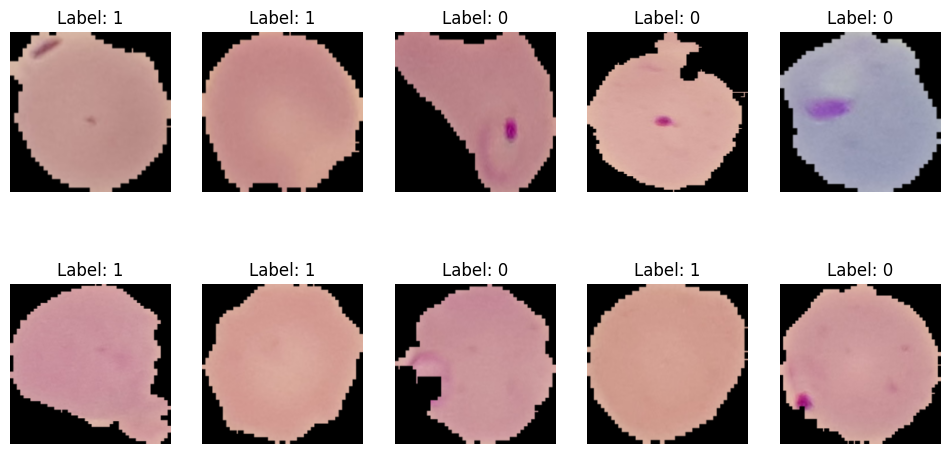

In [16]:
# Ploting images in training dataset before augmentation

run = wandb.init()
artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/train_dataset:v0', type='preprocessed_data')
artifact_dir = artifact.download()

dataset_path = f"{artifact_dir}/train_dataset.npz"
npz_arr = np.load(dataset_path, allow_pickle=True)

dataset_x, dataset_y = npz_arr['dataset_x'], npz_arr['dataset_y']

def plot_original_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i]
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

    plt.show()

plot_original_images(dataset_x, dataset_y, num_images=10)

In [35]:
IMG_SIZE = 224
augment_layers = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.ElasticTransform(p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
])

def add_noise_contrast(image):
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=image.dtype)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image

def augment(image):
    image = np.array(image * 255, dtype=np.uint8)

    augmented = augment_layers(image=image)
    image = augmented['image']

    image = image.astype(np.float32) / 255.0

    image = add_noise_contrast(image)

    return image

In [36]:
def augment_data():
    with wandb.init(project="Malaria-Diagnosis") as run:
        artifact = run.use_artifact(
            'yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/train_dataset:v0',
            type='preprocessed_data'
        )
        artifact_dir = artifact.download()
        print(f"Artifact downloaded to: {artifact_dir}")

        augmented_data = wandb.Artifact(
            name="Augmented_dataset",
            type="preprocessed_data",
            description="An Augmented version of the Malaria train dataset",
        )

        artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

        dataset_x = []
        dataset_y = []

        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)

            print(npz_array.files)
            dataset_x = npz_array['dataset_x']
            dataset_y = npz_array['dataset_y']

            augmented_images = []
            for im in dataset_x:
                augmented_images.append(augment(im))

            dataset_x = np.array(augmented_images, dtype=np.float16)

        with augmented_data.new_file("aug_dataset.npz", mode="wb") as file:
            np.savez(file, dataset_x=dataset_x, dataset_y=dataset_y)

        run.log_artifact(augmented_data)
    print("Augmented data logged successfully.")

In [37]:
augment_data()

wandb: Downloading large artifact train_dataset:v0, 459.38MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.1


Artifact downloaded to: /content/artifacts/train_dataset:v0
['dataset_x', 'dataset_y']


Augmented data logged successfully.


wandb: Downloading large artifact Augmented_dataset:v4, 229.69MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.1


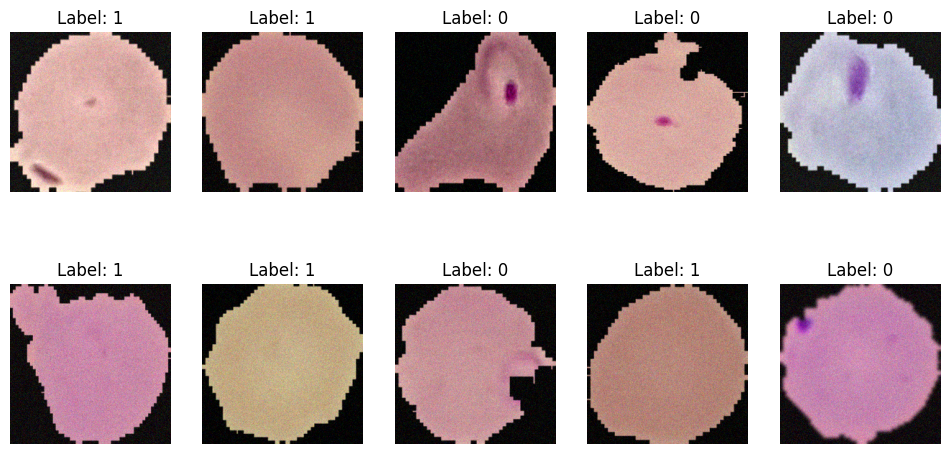

In [38]:
run = wandb.init()
artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/Augmented_dataset:v4', type='preprocessed_data')
artifact_dir = artifact.download()

dataset_path = f"{artifact_dir}/aug_dataset.npz"
npz_arr = np.load(dataset_path, allow_pickle=True)

dataset_x, dataset_y = npz_arr['dataset_x'], npz_arr['dataset_y']

dataset_x = dataset_x.astype(np.float32)

def plot_augmented_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i]
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        plt.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")

    plt.show()


# Call function to plot
plot_augmented_images(dataset_x, dataset_y, num_images=10)

In [6]:
# Define the model
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
N_EPOCHS = CONFIGURATION['N_EPOCHS']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid',
           activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2),
    Dropout(rate=DROPOUT_RATE),

    Conv2D(filters=N_FILTERS * 2 + 4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid',
           activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2),

    Flatten(),

    Dense(CONFIGURATION['N_DENSE_1'], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE),

    Dense(CONFIGURATION['N_DENSE_2'], activation="relu", kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation="sigmoid"),
])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [7]:
# Log model to wandb
def log_model():
    with wandb.init(project="Malaria-Diagnosis") as run:

        untrained_model = wandb.Artifact(
            name="Untrained_model",
            type="model",
            description="The initial version of our custom LeNet model",
            metadata={"model_name": "LeNet", "configuration": CONFIGURATION}
        )

        filename = 'lenet_model.keras'
        lenet_model.save(filename)

        untrained_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(untrained_model)

In [8]:
log_model()

In [11]:
# Having a smooth linear warmup rate at the starts improve our models stability and leads to a better outcome.
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta = 0,
    restore_best_weights=True,
    mode = 'auto',
    verbose=1
)

# Speed and stability
# learning_rate_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='{epoch:02d}--{val_loss:.2f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only = True,
    mode = 'auto',
    save_freq = 'epoch',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [18]:
def train_and_log():
    with wandb.init(project="Malaria-Diagnosis") as run:
        # Load preprocessed dataset
        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/Augmented_dataset:v4', type='preprocessed_data')
        artifact_dir = artifact.download()
        artifact_file = os.path.join(artifact_dir, "aug_dataset.npz")

        with open(artifact_file, 'rb') as file:
            npz_array = np.load(file, allow_pickle=True)
            dataset_x = npz_array['dataset_x']
            dataset_y = npz_array['dataset_y']

        # Create TensorFlow dataset
        d = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))
        train_d = (
            d.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
            .batch(CONFIGURATION['BATCH_SIZE'])
            .prefetch(tf.data.AUTOTUNE)
        )

        # Load untrained model
        artifact = run.use_artifact('yeabsiramersha58-beijing-institute-of-technology/Malaria-Diagnosis/Untrained_model:v1', type='model')
        artifact_dir = artifact.download()
        artifact_file = os.path.join(artifact_dir, "lenet_model.keras")

        lenet_model = tf.keras.models.load_model(artifact_file)

        # Define metrics
        metrics = [
            TruePositives(name='tp'), FalsePositives(name='fp'),
            TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'),
            Recall(name='recall'), AUC(name='auc')
        ]

        # Compile model
        lenet_model.compile(
            optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
            loss=BinaryCrossentropy(),
            metrics=metrics
        )

        checkpoint_dir = './checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)

        checkpoint_filepath = os.path.join(checkpoint_dir, "lenet_checkpoint.keras")

        # Train model
        lenet_model.fit(
            train_d,
            epochs=N_EPOCHS,
            verbose=1,
            callbacks=[
                WandbMetricsLogger(),
                # WandbModelCheckpoint("models.keras", save_best_only=True, save_weights_only=False),
            ],
        )

        # Save trained model
        filename = 'lenet_trained.keras'
        lenet_model.save(filename)

        # Log trained model to W&B
        trained_sequential_model = wandb.Artifact(
            name="Trained_Sequential_model",
            type="model",
            description="A trained version of our model",
            metadata=CONFIGURATION,
        )

        trained_sequential_model.add_file(filename)
        wandb.save(filename)
        run.log_artifact(trained_sequential_model)

    print("Training complete and model logged successfully.")

In [19]:
train_and_log()

wandb: Downloading large artifact Augmented_dataset:v4, 229.69MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb:   1 of 1 files downloaded.  


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5233 - auc: 0.5274 - fn: 116.3750 - fp: 135.0000 - loss: 0.8725 - precision: 0.5499 - recall: 0.5723 - tn: 119.0000 - tp: 165.6250
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6960 - auc: 0.7722 - fn: 71.0000 - fp: 93.3750 - loss: 0.5871 - precision: 0.6925 - recall: 0.7452 - tn: 164.6250 - tp: 207.0000
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7442 - auc: 0.8326 - fn: 67.2500 - fp: 66.6250 - loss: 0.5335 - precision: 0.7436 - recall: 0.7469 - tn: 197.1250 - tp: 205.0000
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8109 - auc: 0.8926 - fn: 58.1250 - fp: 42.2500 - loss: 0.4757 - precision: 0.8475 - recall: 0.7918 - tn: 210.2500 - tp: 225.3750
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8360 - auc: 0.9285 - fn: 56.1250 - fp: 31.7500 - loss: 0.3923 - precision: 0.8619 - recall: 0.8009 - tn: 230.0000 - tp: 218.1250


epoch/accuracy,▁▅▆██
epoch/auc,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/fn,█▃▃▁▁
epoch/fp,█▅▃▂▁
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/precision,▁▄▆▇█
epoch/recall,▁▆▆█▇
epoch/tn,▁▄▆▇█
epoch/tp,▁▆▆█▇


Training complete and model logged successfully.
